In [1]:
import os
import csv

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from tensorflow import keras
import tensorflow as tf
import random as python_random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import editdistance

In [2]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Load data

In [4]:
# Define MIMIC data path
data_path = '../full_experiments1/mimic_data_cardiovascular1/' # mimic_data_sepsis or mimic_data_cardiovascular or mimic_data_ards

# Load training data
train_pos = pd.read_csv(data_path+'train_pos.txt', header=None)
train_neg = pd.read_csv(data_path+'train_neg.txt', header=None)

# Add target class label
train_pos['survival'] = [1 for i in range(train_pos.shape[0])]
train_neg['survival'] = [0 for i in range(train_neg.shape[0])]

In [6]:
# Concat into one data frame; and reorder it
train = pd.concat([train_pos, train_neg]).reset_index()
train_reordered = train.sample(frac=1, random_state=3)

In [7]:
X_train, y_train = train_reordered[0], train_reordered['survival']

# X_train.head()

In [8]:
# Load validation data
validation_pos = pd.read_csv(data_path+'validation_pos.txt', header=None)
validation_neg = pd.read_csv(data_path+'validation_neg.txt', header=None)

# Add target class
validation_pos['survival'] = [1 for i in range(validation_pos.shape[0])]
validation_neg['survival'] = [0 for i in range(validation_neg.shape[0])]

In [9]:
validation = pd.concat([validation_pos, validation_neg]).reset_index()
validation_reordered = validation.sample(frac=1, random_state=3)

# validation_reordered.head()

In [10]:
X_val, y_val = validation_reordered[0], validation_reordered['survival']

# X_val.head()

### Data preprocessing

#### 1.1 Conver all the events into sequence (token) ids

In [11]:
# Set the vocab size and max sequence lenght
vocab_size = 1400 #(max vocab id~=1300 in the training data; ~670 for sepsis)
max_seq_length = 104 #(the maximum sequence length in training/testing data)

In [12]:
# Use a text tokenizer to convert events
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [ ]:
# # Before texts_to_sequences()
# print(f'Before texts_to_sequences():\n {X_train.iloc[1]}\n')

# # After texts_to_sequences()
# print(f'After texts_to_sequences():\n {X_train_sequences[1]}')

#### 1.2 Padding converted sequences

In [13]:
# Pad X_train_sequences and X_val_sequences
X_train_padded = sequence.pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_val_padded = sequence.pad_sequences(X_val_sequences, maxlen=max_seq_length, padding='post')

In [14]:
X_train_padded.shape

(7659, 104)

In [15]:
X_val_padded.shape

(400, 104)

In [16]:
X_val_padded[0]

array([  8,  43,  10,  17,   3,   2,  53, 147,  67, 154,  42, 228,   9,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

## 2. Train the main LSTM model for survival prediction

In [17]:
# For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [18]:
# Fix the random seeds to get consistent models
## ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
seed_value = 3

os.environ['PYTHONHASHSEED']=str(seed_value)

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed_value)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(seed_value)

# The below set_seed() will make random number generation
tf.random.set_seed(seed_value)

# configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

def reset_seeds(seed_value=3):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    np.random.seed(seed_value) 
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

reset_seeds() 

In [19]:
# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [20]:
# Define the model structure
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(vocab_size, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
main_model = keras.Model(inputs, outputs)

main_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         179200    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 376,961
Trainable params: 376,961
Non-trainable params: 0
_________________________________________________________________


In [21]:
main_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

reset_seeds()
model_history = main_model.fit(
    X_train_padded, 
    y_train, 
    epochs=30, 
    batch_size=64, 
    validation_data=(X_val_padded, y_val), 
    callbacks=[early_stopping])

Epoch 1/30
120/120 [==============================] - 10s 30ms/step - loss: 0.5751 - accuracy: 0.7119 - val_loss: 0.6355 - val_accuracy: 0.5800
Epoch 2/30
120/120 [==============================] - 3s 23ms/step - loss: 0.4939 - accuracy: 0.7521 - val_loss: 0.5893 - val_accuracy: 0.6850
Epoch 3/30
120/120 [==============================] - 3s 23ms/step - loss: 0.4745 - accuracy: 0.7702 - val_loss: 0.6962 - val_accuracy: 0.6450
Epoch 4/30
120/120 [==============================] - 3s 24ms/step - loss: 0.4506 - accuracy: 0.7881 - val_loss: 0.6315 - val_accuracy: 0.6800
Epoch 5/30
120/120 [==============================] - 3s 23ms/step - loss: 0.4398 - accuracy: 0.7962 - val_loss: 0.5963 - val_accuracy: 0.7050
Epoch 6/30
120/120 [==============================] - 3s 23ms/step - loss: 0.4265 - accuracy: 0.8049 - val_loss: 0.7031 - val_accuracy: 0.6600
Epoch 7/30
120/120 [==============================] - 3s 23ms/step - loss: 0.4353 - accuracy: 0.7929 - val_loss: 0.6851 - val_accuracy: 0.692

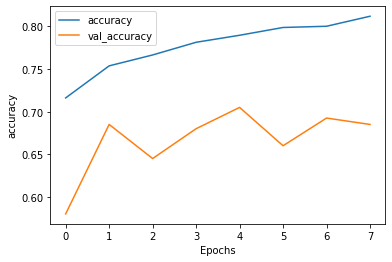

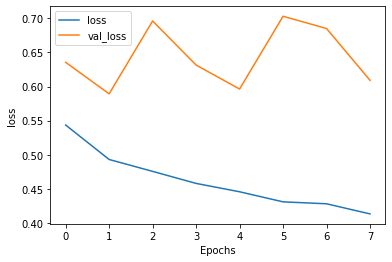

In [22]:
# Visualize the training/validation accuracy and loss
plot_graphs(model_history, "accuracy")
plot_graphs(model_history, "loss")

In [23]:
# Get the predicted target class: if pred > 0.5, then y_pred = 1; else, y_pred = 0
y_pred = np.array([1 if pred > 0.5 else 0 for pred in main_model.predict(X_val_padded)])

In [24]:
# Calculate the validation accuracy
validation_acc = sum(y_pred == y_val)/len(y_val)
validation_acc

0.705

In [25]:
# Get the confusion matrix
confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
confusion_matrix_df

,Pred:pos,Pred:neg
True:pos,176,24
True:neg,94,106


In [26]:
# Counts of positive and negative predictions
pd.value_counts(y_pred)

1    270
0    130
dtype: int64

### 2.1 Save the trained classifier for evaluation

In [ ]:
# # Create a saved model folder `main_model`.
# main_model.save('../full_experiments1/experiment_cardiovascular1/main_model')

In [ ]:
# main_model = keras.models.load_model('../full_experiments1/experiment_cardiovascular1/main_model')

## 3. Get the negative predictions from LSTM, for counterfactual explanations

In [27]:
# Get these instances of negative predictions
X_pred_negative = X_val_padded[y_pred == 0]

X_pred_negative

array([[ 8, 43, 10, ...,  0,  0,  0],
       [ 8, 10, 37, ...,  0,  0,  0],
       [ 8, 23,  6, ...,  0,  0,  0],
       ...,
       [ 8, 15,  2, ...,  0,  0,  0],
       [ 8, 33, 55, ...,  0,  0,  0],
       [ 8, 33, 11, ...,  0,  0,  0]], dtype=int32)

In [28]:
X_pred_negative.shape

(130, 104)

In [30]:
# Use the index of negative predictions to find the original row with the diagnosis codes
# np.where(y_pred == 0)
pred_neg_data = validation_reordered.iloc[np.where(y_pred == 0)]

# pred_neg_data.head()

In [31]:
# Convert negatively predicted instances back to medical event form
original_event_sequences = tokenizer.sequences_to_texts(X_pred_negative)

# original_event_sequences[:5]

In [32]:
pred_pos_data = validation_reordered.iloc[np.where(y_pred == 1)]

pred_pos_data.shape

(270, 3)

### Export as the desired input format of the DRG framework

In [33]:
out_datapath = data_path

In [ ]:
pd.DataFrame(pred_neg_data[0]).to_csv(path_or_buf=out_datapath+'test_neg.txt', index=False, header=False, sep=' ', quoting=csv.QUOTE_NONE, escapechar=' ')

In [ ]:
pd.DataFrame(pred_neg_data['diag']).to_csv(path_or_buf=out_datapath+'test_neg_diag.txt', index=False, header=False, sep=' ', quoting=csv.QUOTE_NONE, escapechar=' ')


Here, we need to use the inference script from the DRG framework (instructions in the README file) to modify those 110 negative predictions into positive instances. After that, we import the transformed results as below.

### 3.1 DeleteOnly model results

In [34]:
# Load the transformed data
results_path = '../full_experiments1/experiment_cardiovascular1/working_dir_cardiovascular1_delete1/'
trans_results_delete = pd.read_csv(results_path+'preds', header=None)

In [35]:
X_test_sequences = tokenizer.texts_to_sequences(trans_results_delete[0])

X_test_padded = sequence.pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

### 3.2 DeleteAndRetrieve model results

In [36]:
# Load the transformed data
delete_generate_results_path = '../full_experiments1/experiment_cardiovascular1/working_dir_cardiovascular1_delete_ret1/'
delete_generate_results = pd.read_csv(delete_generate_results_path+'preds', header=None)

In [37]:
X_test_sequences2 = tokenizer.texts_to_sequences(delete_generate_results[0])

X_test_padded2 = sequence.pad_sequences(X_test_sequences2, maxlen=max_seq_length, padding='post')

### 3.3 Use 1NN baseline method to modify the negatively predicted instances

In [38]:
# Fit an unsupervised 1NN with all the positive seuquences, using 'hamming' distance
nn_model = NearestNeighbors(1, metric='hamming')

target_label = 1 
X_target_label = X_train_padded[y_train == target_label] # training using the true labels

nn_model.fit(X_target_label)

/home/dsv/zhwa9764/miniconda3/envs/py37-cuda11/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


NearestNeighbors(metric='hamming', n_neighbors=1)

In [39]:
# Find the closest neighbor (positive sequence) with the minimum 'hamming' distance, take it as a counterfactual
closest = nn_model.kneighbors(X_pred_negative, return_distance=False)
trans_results_nn = X_target_label[closest[:, 0]]

trans_results_nn[0]

array([ 8, 37, 10, 66, 33,  6, 37, 10,  6, 37, 42, 87,  9,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0], dtype=int32)

In [40]:
# Rename 'trans_results_nn' to 'X_test_padded3' for result comparison
X_test_padded3 = trans_results_nn

### 3.4 Convert transformed results to event sequence format

In [41]:
# Convert transformed sequences back to the form of original event sequences
trans_event_sequences1 = tokenizer.sequences_to_texts(X_test_padded)
trans_event_sequences2 = tokenizer.sequences_to_texts(X_test_padded2)
trans_event_sequences3 = tokenizer.sequences_to_texts(X_test_padded3)

## 4. Results comparison

### 4.1 Comparison between fraction of valid CFs (i.e. successfully generated counterfactuals)

In [42]:
# Get the total counts 
test_size = X_pred_negative.shape[0]

test_size

130

In [43]:
main_model.predict(X_test_padded).shape

(130, 1)

In [44]:
# Fraction of valid transformed sequences, for DeleteOnly
fraction_success = np.sum(main_model.predict(X_test_padded) > 0.5)/test_size
print(round(fraction_success, 4))

0.3385


In [45]:
# For DeleteAndRetrieve
fraction_success2 = np.sum(main_model.predict(X_test_padded2) > 0.5)/test_size
print(round(fraction_success2, 4))

0.2846


In [46]:
# For 1NN modification
fraction_success3 = np.sum(main_model.predict(X_test_padded3) > 0.5)/test_size
print(round(fraction_success3, 4))

0.7538


### 4.2 Local outlier factor (LOF score)

In [47]:
# Fit the model for novelty detection (novelty=True), in order to get LOF score
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
# clf.fit(X_train_padded)
clf.fit(X_target_label) # use the target class to train, instead of all


LocalOutlierFactor(contamination=0.1, novelty=True)

In [48]:
# Get the LOF score for leave-out validation data
y_pred_val = clf.predict(X_val_padded)

n_error_val = y_pred_val[y_pred_val == -1].size

In [49]:
validation_size = X_val_padded.shape[0]
outlier_score_val = n_error_val/validation_size

outlier_score_val

0.105

In [50]:
# Get the LOF score for DeleteOnly results
y_pred_test = clf.predict(X_test_padded)
n_error_test = y_pred_test[y_pred_test == -1].size

outlier_score_test = n_error_test / test_size
print(round(outlier_score_test, 4))

0.0769


In [51]:
# Get the outlier score for DeleteAndRetrieve results
y_pred_test2 = clf.predict(X_test_padded2)
n_error_test2 = y_pred_test2[y_pred_test2 == -1].size

outlier_score_test2 = n_error_test2 / test_size
print(round(outlier_score_test2, 4))

0.0846


In [52]:
# Outlier score for 1NN baseline method
y_pred_test3 = clf.predict(X_test_padded3)
n_error_test3 = y_pred_test3[y_pred_test3 == -1].size

outlier_score_test3 = n_error_test3 / test_size
print(round(outlier_score_test3, 4))

0.1


### 4.3 BLEU-4 score (cumulative 4-gram BLEU score) 

In [53]:
# Define smoothing function
chencherry = SmoothingFunction()

# Define a function to get pairwise BLEU scores
def get_pairwise_bleu(original, transformed):
    # 'weights=[0.25, 0.25, 0.25, 0.25]' means that calculate 4-gram BLEU scores cumulatively
    results = [sentence_bleu(
        references=[pair[0].split()], 
        hypothesis=pair[1].split(), 
        weights=[0.25, 0.25, 0.25, 0.25], 
        smoothing_function=chencherry.method1) 
        for pair in zip(original, transformed)]
    
    return results

In [54]:
pairwise_bleu = get_pairwise_bleu(original_event_sequences, trans_event_sequences1)
avg_bleu = sum(pairwise_bleu)/test_size
print(round(avg_bleu, 4))

0.1558


In [55]:
pairwise_bleu2 = get_pairwise_bleu(original_event_sequences, trans_event_sequences2)
avg_bleu2 = sum(pairwise_bleu2)/test_size
print(round(avg_bleu2, 4))

0.1564


In [56]:
pairwise_bleu3 = get_pairwise_bleu(original_event_sequences, trans_event_sequences3)
avg_bleu3 = sum(pairwise_bleu3)/test_size
print(round(avg_bleu3, 4))

0.0597


### 4.4 Edit distance (Levenshtein)

In [62]:
def get_edit_distance(original, transformed):
    edit_distance_pair = [editdistance.eval(o, t) for o, t in zip(original.tolist(), transformed.tolist())]
    edit_score = np.mean(edit_distance_pair)
    
    return round(edit_score, 4)


In [63]:
get_edit_distance(X_test_padded, X_pred_negative)

33.7923

In [65]:
get_edit_distance(X_test_padded2, X_pred_negative)

32.6308

In [66]:
get_edit_distance(X_test_padded3, X_pred_negative)

34.2308

### Update: Extract valid counterfactuals for qualitative evaluation

In [ ]:
valid_flags = main_model.predict(X_test_padded) > 0.5
valid_flags2 = main_model.predict(X_test_padded2) > 0.5
valid_flags3 = main_model.predict(X_test_padded3) > 0.5

In [ ]:
all_valid_idx = np.where((valid_flags == True) & (valid_flags2 == True) & (valid_flags3 == True), True, False)

all_valid_idx.reshape(-1)

In [ ]:
transformed_df = pd.DataFrame(original_event_sequences)
transformed_df['all_valid'] = all_valid_idx
transformed_df['count'] = transformed_df[0].apply(lambda x: len([event for event in x.split()]))

transformed_df

In [ ]:
transformed_df['delete'] = trans_event_sequences1
transformed_df['delete_retrieve'] =trans_event_sequences2
transformed_df['nn'] = trans_event_sequences3

In [ ]:
transformed_df

In [ ]:
selected_idx = np.where((transformed_df['count'] >= 10) & (transformed_df['count'] <= 30) & (transformed_df['all_valid'] == True), True, False)


In [ ]:
selected_idx

In [ ]:
valid_transformed_df = transformed_df[selected_idx.reshape(-1)]

In [ ]:
valid_transformed_df

In [ ]:
valid_transformed_df.index

In [ ]:
valid_transformed_df.iloc[0]['nn']

In [ ]:
valid_transformed_df.to_csv(path_or_buf='valid_transformations.csv', 
                            index=True, header=True, sep=',')
